In [348]:
# Predicting players rating
import sqlite3
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
%matplotlib inline

In [327]:
# Establishing connection.
cnx = sqlite3.connect('database.sqlite')
dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)
print(dd)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [328]:
# Querying the table and converting it into a dataframe
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [329]:
# Understanding the features
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [330]:
# Dropping the columns id and date as they have no impact in predicting the player's rating
df = df.drop(['id','date','player_fifa_api_id', 'player_api_id',],axis=1)

In [331]:
#Identifying the unique value counts and the type of the features in our data frame
for col in df.columns:
    unique_val_count = len(df[col].unique())
    print("{col}--> {unique_val_count}..{typ}".format(col=col, unique_val_count=unique_val_count, typ=df[col].dtype))

overall_rating--> 62..float64
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..float64
gk_kicking--> 98..float64
gk_positioning--> 95..float64
gk_reflexes

In [332]:
# Replacing the object datatypes with dummy values
Modified_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
Modified_df.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_left,preferred_foot_right,attacking_work_rate_None,attacking_work_rate_high,attacking_work_rate_le,attacking_work_rate_low,attacking_work_rate_medium,attacking_work_rate_norm,attacking_work_rate_stoc,attacking_work_rate_y,defensive_work_rate_0,defensive_work_rate_1,defensive_work_rate_2,defensive_work_rate_3,defensive_work_rate_4,defensive_work_rate_5,defensive_work_rate_6,defensive_work_rate_7,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [333]:
# Finding the correlation of other variables with our target variable
feature = []
corr_val = []
for x in Modified_df.columns:
    related = Modified_df['overall_rating'].corr(Modified_df[x]).round(2)
    feature.append(x)
    corr_val.append(related)
player_feature = pd.DataFrame({'Feature':feature,'Correlation':corr_val})
player_feature = player_feature.sort_values(by=['Correlation'],ascending=False)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
print(player_feature)

                       Feature  Correlation
0               overall_rating         1.00
1                    potential         0.77
15                   reactions         0.77
5                short_passing         0.46
10                long_passing         0.44
11                ball_control         0.44
25                      vision         0.43
17                  shot_power         0.43
21                  long_shots         0.39
26                   penalties         0.39
24                 positioning         0.37
2                     crossing         0.36
8                        curve         0.36
6                      volleys         0.36
7                    dribbling         0.35
9           free_kick_accuracy         0.35
3                    finishing         0.33
19                     stamina         0.33
20                    strength         0.32
22                  aggression         0.32
4             heading_accuracy         0.31
18                     jumping  

In [335]:
# From the above correlation, we identify the important features for our prediction
df_actual = Modified_df[['reactions','potential','crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots','aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle','attacking_work_rate_medium','defensive_work_rate_medium','gk_diving','gk_kicking','overall_rating']]
df_actual.head()

,reactions,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,attacking_work_rate_medium,defensive_work_rate_medium,gk_diving,gk_kicking,overall_rating
0,47.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,1,1,6.0,10.0,67.0
1,47.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,1,1,6.0,10.0,67.0
2,47.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,1,1,6.0,10.0,62.0
3,46.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,1,1,5.0,9.0,61.0
4,46.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,1,1,5.0,9.0,61.0


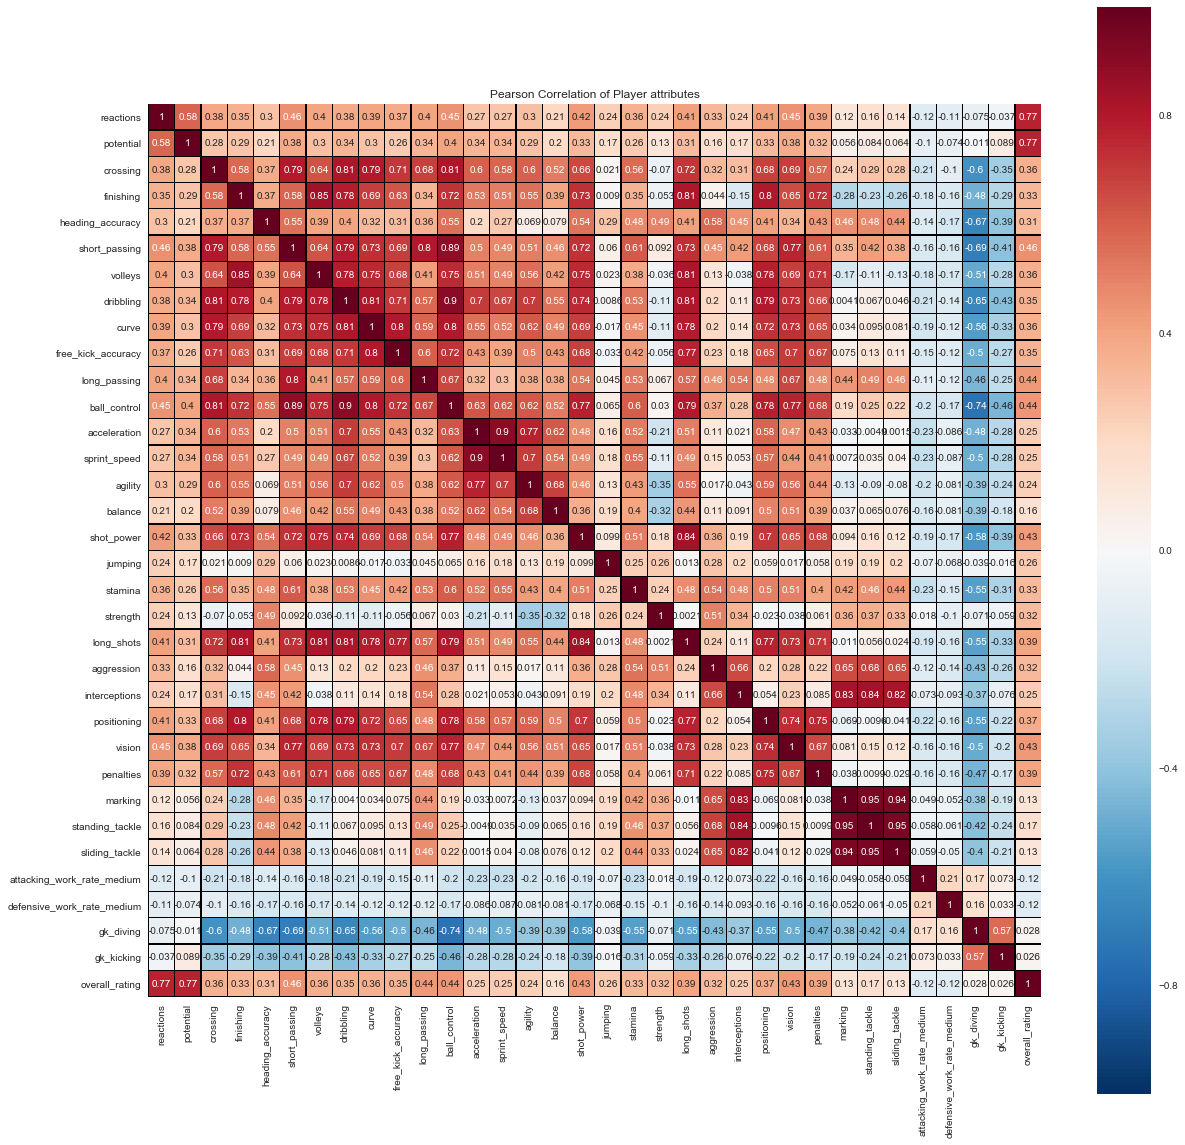

In [336]:
# Identifying the correlation using the Pearson heatmap
f, ax = plt.subplots(figsize=(20, 20))

plt.title('Pearson Correlation of Player attributes')

sns.heatmap(df_actual.corr(),linewidths=0.25,vmax=1.0, square=True,linecolor='black', annot=True)

In [337]:
# Setting the target variable as 'Overall Rating'
target = df_actual.pop('overall_rating')

In [212]:
print(target.shape[0])

183978


In [213]:
# Getting the count of null values of the target variable
target.isnull().values.sum()

836

In [338]:
# Populating the values of the target variable with the mean value
y = target.fillna(target.mean())

In [339]:
y.isnull().values.any()

False

In [340]:
x = df_actual.apply(lambda x: x.fillna(x.mean()),axis=0)
print(x.mean())

reactions                     66.103706
potential                     73.460353
crossing                      55.086883
finishing                     49.921078
heading_accuracy              57.266023
short_passing                 62.429672
volleys                       49.468436
dribbling                     59.175154
curve                         52.965675
free_kick_accuracy            49.380950
long_passing                  57.069880
ball_control                  63.388879
acceleration                  67.659357
sprint_speed                  68.051244
agility                       65.970910
balance                       65.189496
shot_power                    61.808427
jumping                       66.969045
stamina                       67.038544
strength                      67.424529
long_shots                    53.339431
aggression                    60.948046
interceptions                 52.009271
positioning                   55.786504
vision                        57.873550


In [341]:
x.isnull().values.any()

False

###################################
Train dataset summary
###################################
The prediction percentage is : 84.0 % 

The coefficicents witn respect to the features are :
                       features  coefficients
0                    reactions      0.217319
1                    potential      0.390049
2                     crossing      0.022770
3                    finishing      0.011125
4             heading_accuracy      0.061613
5                short_passing      0.044975
6                      volleys      0.002910
7                    dribbling     -0.012819
8                        curve      0.011022
9           free_kick_accuracy      0.011058
10                long_passing      0.007659
11                ball_control      0.125955
12                acceleration      0.003619
13                sprint_speed      0.006235
14                     agility     -0.009230
15                     balance      0.005788
16                  shot_power      0.015345
17

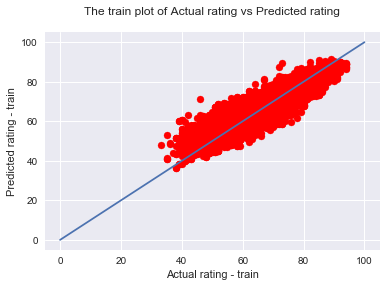

In [359]:
# Analyzing and the understanding the parameters on the training dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
Lin_regr = LinearRegression()
Lin_regr.fit(x_train, y_train)
train_pred = Lin_regr.predict(x_train)
print("###################################")
print("Train dataset summary")
print("###################################")
print("The prediction percentage is :",Lin_regr.score(x_train, y_train).round(2)*100,"%","\n")
train_coef = pd.DataFrame(list(zip(df_actual.columns,np.transpose(Lin_regr.coef_))),columns=["features","coefficients"])
print("The coefficicents witn respect to the features are :\n",train_coef,"\n")
print("Intercept: ",Lin_regr.intercept_,"\n")
# Calculating the mean squared value
mse = mean_squared_error(y_train, train_pred)
print("MSE: ",mse,"\n")
print("The root mean squared value(RMSE) is : ",np.sqrt(mse),"\n")
plt.scatter(y_train,train_pred,color="red")
plt.plot([0, 100], [0, 100], '-')
plt.xlabel("Actual rating - train")
plt.ylabel("Predicted rating - train")
plt.title("The train plot of Actual rating vs Predicted rating\n")
plt.show()

###################################
Test dataset summary
###################################
The prediction percentage is : 84.0 % 

The coefficicents witn respect to the features are :
                       features  coefficients
0                    reactions      0.216877
1                    potential      0.389567
2                     crossing      0.023738
3                    finishing      0.007947
4             heading_accuracy      0.063870
5                short_passing      0.043406
6                      volleys      0.002325
7                    dribbling     -0.010779
8                        curve      0.011257
9           free_kick_accuracy      0.010811
10                long_passing      0.006206
11                ball_control      0.125579
12                acceleration      0.004136
13                sprint_speed      0.005853
14                     agility     -0.006209
15                     balance      0.006347
16                  shot_power      0.017433
17 

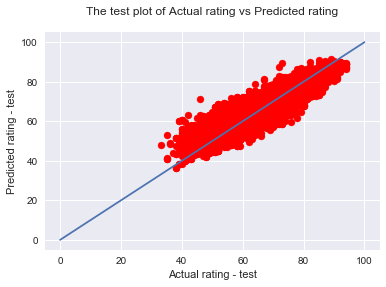

In [360]:
# Analyzing and the understanding the parameters on the test dataset
Lin_regr = LinearRegression()
Lin_regr.fit(x_test, y_test)
test_pred = Lin_regr.predict(x_test)
print("###################################")
print("Test dataset summary")
print("###################################")
print("The prediction percentage is :",Lin_regr.score(x_test, y_test).round(2)*100,"%","\n")
train_coef = pd.DataFrame(list(zip(df_actual.columns,np.transpose(Lin_regr.coef_))),columns=["features","coefficients"])
print("The coefficicents witn respect to the features are :\n",train_coef,"\n")
print("Intercept: ",Lin_regr.intercept_,"\n")
# Calculating the mean squared value
mse = mean_squared_error(y_test, test_pred)
print("MSE: ",mse,"\n")
print("The root mean squared value(RMSE) is : ",np.sqrt(mse),"\n")
plt.scatter(y_train,train_pred,color="red")
plt.plot([0, 100], [0, 100], '-')
plt.xlabel("Actual rating - test")
plt.ylabel("Predicted rating - test")
plt.title("The test plot of Actual rating vs Predicted rating\n")
plt.show()